In [ ]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
import tqdm
import jax 
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision
import jax.numpy as jnp
import math

In [ ]:
# mount the Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DSA4212/assignment_2
%ls

/content/drive/MyDrive/DSA4212/assignment_2
 assignment_2_data/
 dsa4212_2022_assignment_2-2.pdf
'Extension using collaborative filtering'
'Factor model from scratch.ipynb'
'Factor model using lecture and extensions'
'Normal baseline model'
 train_data.csv
 tutorial_matrix_factorization_CLASS.ipynb
 tutorial_matrix_factorization.ipynb
 tutorial_newton.ipynb
 tutorial_reconstruction.ipynb
 valid_data.csv


In [ ]:
import jax 
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision


import jax.numpy as jnp
import numpy as onp
import pylab as plt
import tqdm

import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy

## Reading in data ##

In [ ]:
anime_data = pd.read_csv('assignment_2_data/assignment_2_anime.csv')
train_data_og = pd.read_csv('assignment_2_data/assignment_2_ratings_train.csv')
test_data_og = pd.read_csv('assignment_2_data/assignment_2_ratings_test.csv')

## Functions needed to transform data into usable form for factor model ##

In [ ]:
# This function takes a column that might have repeats and assigns all unique values an id
# first output key_to_id is a dictionary {unique_id:index}
# second output is for each value in the column we get the index
# third output is just the no. of unique values
def encode_column(column):
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, onp.array([key_to_id[x] for x in column]), len(keys)

In [ ]:
# This is basically to apply the encode_column function on our columns of choice
def encode_df(data):
    anime_ids, data['anime_id'], num_anime = encode_column(data['anime_id'])
    user_ids, data['user_id'], num_users = encode_column(data['user_id'])
    return data, num_users, num_anime, user_ids, anime_ids

## Train and validation split ##

In [ ]:
onp.random.seed(15)
train, valid = train_test_split(train_data_og, test_size = 0.2)

train_data = train.reset_index()[['user_id', 'anime_id', 'rating']]
valid_data = valid.reset_index()[['user_id', 'anime_id', 'rating']]

train_data, num_users, num_anime, user_ids, anime_ids = encode_df(train_data)
# Multiple entries of user_id meaning that
#train_data.groupby("anime_id").count()
#train_data.groupby("rating").count()


In [ ]:
ratings_list = train_data_og.rating.values
u_list = train_data.user_id.values
v_list = train_data.anime_id.values



## First factor model ##
1. Number of latent factors : 3  
2. Initialisation distrubtion : N(0,1)
3. Validation MSE: 27 - 36

Observations:  
It was observed that MSE is quite high relative to our other models. This is because our predictions tend to go past 10 which does not make sense. This could be remedied with smaller initiasations for our latent factor values or by flooring the predictions to be 10 if the predictions are above 10. Also it is likely that the gradient descent has not converged to minimum.  
This could be due to to low number of iterations, large starting point or eta being too high.

In [ ]:
# Basically the main difference between this implementation and the prof's implementation
# is that we were given a pxq sparse matrix A with the ratings of all users+anime_id combinations
# we also assumed that we had a u_list/user list where the entries range from 1-p and f_list/anime list where the entries range from 1-q
# Rating of first person = A[u_list[0],f_list[0]]
# But for our case it is not possible as we are given a list of anime_ids and user_ids so we need to think of someway to reexpress them as indices so that they will
# be bound by values (1-p) and (1-q) respectively

ratings_list = train_data.rating.values
u_list = train_data.user_id.values
v_list = train_data.anime_id.values

def model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  MSE = onp.mean( (predictions - ratings_list)**2 )
  return MSE


In [ ]:
# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )

In [ ]:
onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)

In [ ]:
#rate_getter = lambda x: 1 if x<1 else (10 if x>10 else x) 
#vfunc = onp.vectorize(rate_getter)
#a = U_init[u_list.astype(int)] * V_init[v_list.astype(int)]
#b = a.sum(axis = 1)
#int_mat = U_init[u_list.astype(int)] * V_init[v_list.astype(int)]
#predictions = vfunc(int_mat.sum(axis = 1))
#predictions = int_mat.sum(axis = 1)
#predictions.shape

(3548854,)

In [ ]:
# Gradient descent
niter = 100
eta = 100.
loss_traj = []

U = onp.copy(U_init)
V = onp.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )


100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


In [ ]:
# Encode test data with the same as training data which is just saying that we want to make sure that the same user/anime are given the 
# same index mapping in both data sets
def encode_new_data(test_data, user_ids, anime_ids):
    """ Encodes test_df with the same encoding as train_df.
    """
    # This is to check for each row entry in the test data set if it exists in the training set
    df_val_chosen = test_data['anime_id'].isin(anime_ids.keys()) or test_data['user_id'].isin(user_ids.keys())

    # Only use rows in the test data that exists for 
    test_data = test_data[df_val_chosen]
    test_data['anime_id'] =  onp.array([anime_ids[x] for x in test_data['anime_id']])
    test_data['user_id'] = onp.array([user_ids[x] for x in test_data['user_id']])
    return test_data

valid_data = encode_new_data(valid_data, user_ids, anime_ids)

<ipython-input-39-e5adc736ebea>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anime_id'] =  onp.array([anime_ids[x] for x in test_data['anime_id']])
<ipython-input-39-e5adc736ebea>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['user_id'] = onp.array([user_ids[x] for x in test_data['user_id']])


In [ ]:
#df_val_chosen = test_data['anime_id'].isin(anime_ids.keys()) & test_data['user_id'].isin(user_ids.keys())
#test_data.groupby("rating").count()

In [ ]:
u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )
MSE


Array(36.68778128, dtype=float64)

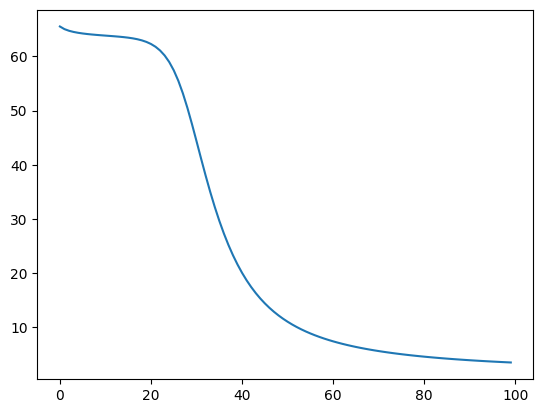

In [ ]:
plt.plot(loss_traj)

## Second model experimentation ##
- Experimenting with different SDs for our initialisation distribution
1. N(0,1/10^2) : 24.99
2. N(0,1/10^4) : 26.79
3. N(0,1/10^6) : 29.868   
Observations:  
It was also observed from the loss trajectory graphs that as we decrease the SD of the normal distribution that we use to initialise the U_init and V_init, the model takes a longer time to start decreasing training MSE.

In [ ]:
# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )

In [ ]:
onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)
# Gradient descent
niter = 100
eta = 100.
loss_traj = []

U = onp.copy(U_init)
V = onp.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

# Test MSE
u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )
MSE

100%|██████████| 100/100 [00:04<00:00, 22.96it/s]


Array(29.86772856, dtype=float64)

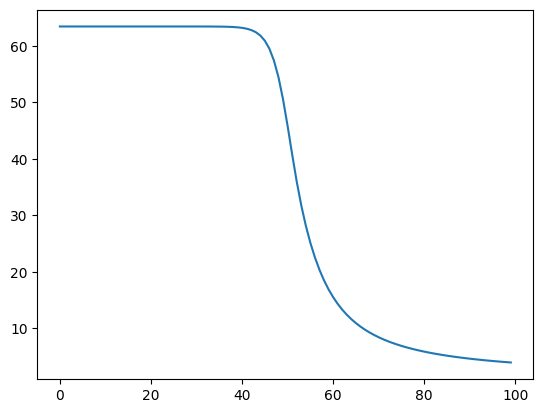

In [ ]:
plt.plot(loss_traj)

## Third model experimentation ##
- Experiment with different number of latent factors  
- Initialisation distribution : N(0,1)  
1. 20: 33.04
2. 50: 46.93
3. 100: 75.12  
Observations:  
While we can see that the validation MSE gets considerably worse, it is also observed from the loss trajectory plots starts decreasing faster as we increase the number of latent factors. This is probably from overfitting as increasing the number of latent factors makes our model more flexible.


In [ ]:
# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )

onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)

# Gradient descent
niter = 100
eta = 100.
loss_traj = []

U = onp.copy(U_init)
V = onp.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

# Test MSE
u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )
MSE

100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Array(75.11673468, dtype=float64)

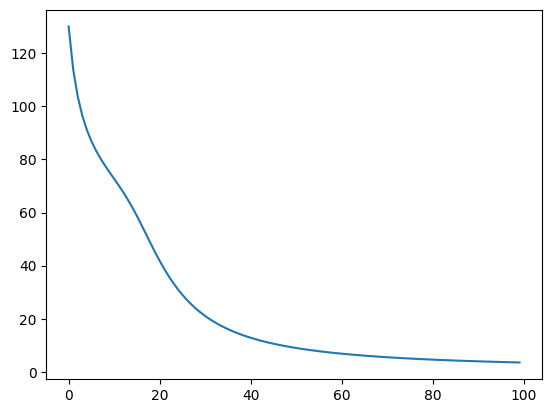

In [ ]:
plt.plot(loss_traj)

## Fourth model experimentation ##  
- Regularisation. The aim is to get great validation MSE with a relative small number of latent factors.  
1. Lambda  
- 0.001, MSE : 27.18  
- 0.01, MSE : 28.23 
- 1, MSE : 29.288  
- It seems that the lambda regularisation does not do much to validation MSE but it does cause the decrease in training MSE to be slower.  
2. Alternative minimisation  
- MSE : 65.495  
- It seems that decrease in training MSE is way slower.  

3. Change in eta  
- 50 : 43.61
- 10 : 65.72
- 1 : 66.471  
- Not surprisingly, decrease in training MSE is slower as eta is slower.




In [ ]:
def model_reg_lam(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  lamb = 1
  predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  MSE = onp.mean( (predictions - ratings_list)**2 )
  # Penalising
  reg = lamb * jnp.mean( U**2 ) + lamb * jnp.mean( V**2 )
  MSE += reg
  return MSE

# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model_reg_lam, argnums=0) )
model_grad_V = jax.jit( jax.grad(model_reg_lam, argnums=1) )

onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)
# Gradient descent
niter = 100
eta = 100.
loss_traj = []

U = onp.copy(U_init)
V = onp.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model_reg_lam(U,V) )

# Test MSE
u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )

MSE


100%|██████████| 100/100 [00:06<00:00, 14.59it/s]


Array(29.28763524, dtype=float64)

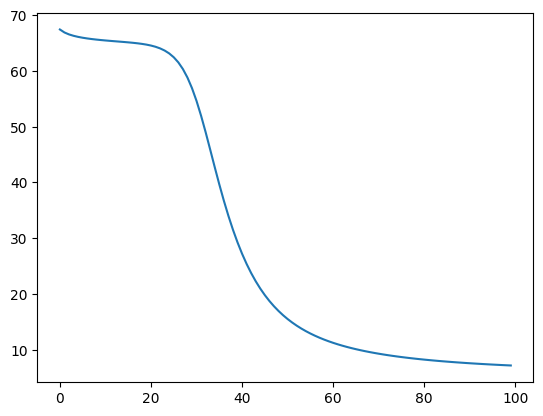

In [ ]:
plt.plot(loss_traj)

In [ ]:
onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)



U = onp.copy(U_init)
V = onp.copy(V_init)

def model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  #lamb = 0.001
  predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  MSE = onp.mean( (predictions - ratings_list)**2 )
  # Penalising
  #reg = lamb * jnp.mean( U**2 ) + lamb * jnp.mean( V**2 )
  #MSE += reg
  return MSE

# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )


# Gradient descent
niter = 100
eta = 100.
loss_traj = []


for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  #grad_v = model_grad_V(U,V)


  # do the GD update
  U = U - eta * grad_u
  #V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_v = model_grad_V(U,V)

  # do the GD update
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

# Test MSE
u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )

MSE


100%|██████████| 100/100 [00:05<00:00, 18.62it/s]


Array(65.49526344, dtype=float64)

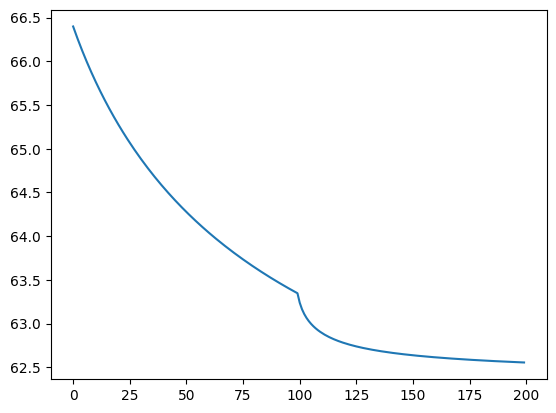

In [ ]:
plt.plot(loss_traj)

In [ ]:
onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)



U = onp.copy(U_init)
V = onp.copy(V_init)

def model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  #lamb = 0.001
  predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  MSE = onp.mean( (predictions - ratings_list)**2 )
  # Penalising
  #reg = lamb * jnp.mean( U**2 ) + lamb * jnp.mean( V**2 )
  #MSE += reg
  return MSE

# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )


# Gradient descent
niter = 100
eta = 1.
loss_traj = []


for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)


  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )


# valid MSE
u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )

MSE


100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


Array(66.47096463, dtype=float64)

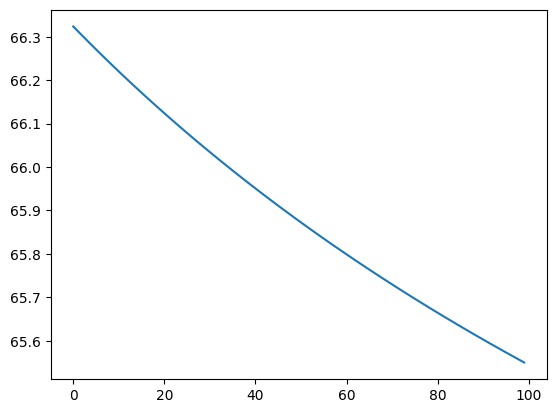

In [ ]:
plt.plot(loss_traj)

## Fifth model experimentation ##
- Using Momentum, doesn't seem to change the convergence in the loss trajectory plot.
- Using annealing method

In [ ]:
ratings_list = train_data.rating.values
u_list = train_data.user_id.values
v_list = train_data.anime_id.values

def model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  MSE = onp.mean( (predictions - ratings_list)**2 )
  return MSE

# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )

onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)

# Gradient descent
niter = 100
eta = 100.
loss_traj = []
B = 0.9
U = onp.copy(U_init)
V = onp.copy(V_init)

U_tracker = [U_init]
V_tracker = [V_init]

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)
  
  # do the GD update
  U = U - eta * grad_u + B*(U-U_tracker[-1])
  V = V - eta * grad_v + B*(V-V_tracker[-1])

  U_tracker.append(U)
  V_tracker.append(V)
  # monitor the loss
  loss_traj.append( model(U,V) )

u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )
MSE


100%|██████████| 100/100 [00:06<00:00, 14.58it/s]


Array(36.68778128, dtype=float64)

Array(3.48069216, dtype=float64)

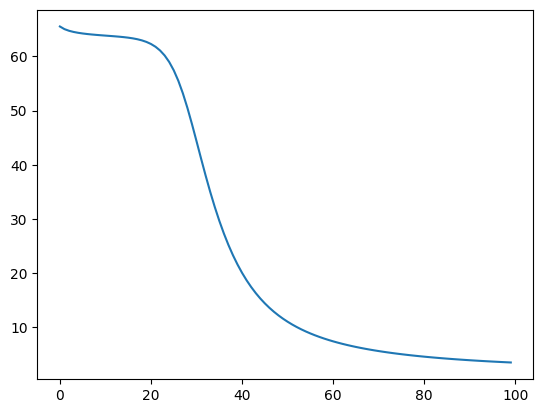

In [ ]:
plt.plot(loss_traj)
loss_traj[-1]

In [ ]:
# Using annealing
ratings_list = train_data.rating.values
u_list = train_data.user_id.values
v_list = train_data.anime_id.values

def model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  MSE = onp.mean( (predictions - ratings_list)**2 )
  return MSE

# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )

onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)

# Gradient descent
niter = 100
eta = 100.
loss_traj = []
B = 0.9
U = onp.copy(U_init)
V = onp.copy(V_init)

U_tracker = [U_init]
V_tracker = [V_init]

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)
  
  # do the GD update
  U = U - eta * grad_u #+ B*(U-U_tracker[-1])
  V = V - eta * grad_v #+ B*(V-V_tracker[-1])

  eta = eta* 0.9
  U_tracker.append(U)
  V_tracker.append(V)
  # monitor the loss
  loss_traj.append( model(U,V) )

u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
predictions = jnp.sum(U[u_list_val.astype(int)] * V[v_list_val.astype(int)], axis=1)
MSE = onp.mean( (predictions - ratings_list_val)**2 )
MSE



100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


Array(66.63523263, dtype=float64)

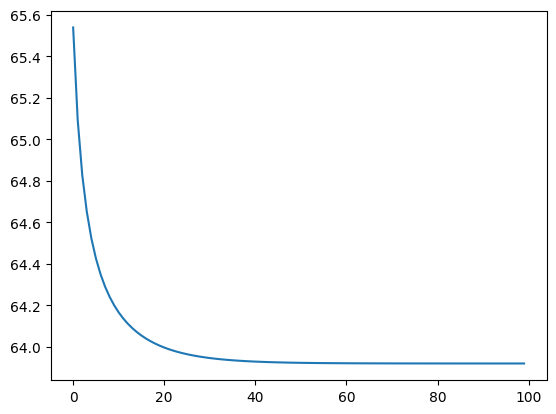

In [ ]:
plt.plot(loss_traj)

## Altering predictions ##
- Make predicted scores that go below 1 equals to 1 and scores that go above 10 as 10 as this might greatly affect MSE.

In [ ]:
rate_getter = lambda x: 1 if x<1 else (10 if x>10 else x) 
vfunc = onp.vectorize(rate_getter)
#a = U_init[u_list.astype(int)] * V_init[v_list.astype(int)]
#b = a.sum(axis = 1)
#int_mat = U_init[u_list.astype(int)] * V_init[v_list.astype(int)]
#predictions = vfunc(int_mat.sum(axis = 1))
#MSE = onp.mean( (predictions - ratings_list)**2 )
#predictions = int_mat.sum(axis = 1)
#predictions.shape

In [ ]:
ratings_list = train_data.rating.values
u_list = train_data.user_id.values
v_list = train_data.anime_id.values

def model(U, V):
  """
  U -- (p, r) -- factors of the p users
  V -- (q, r) -- factors of the q films
  """
  #predictions = jnp.sum(U[u_list.astype(int)] * V[v_list.astype(int)], axis=1)
  int_mat = U[u_list.astype(int)] * V[v_list.astype(int)]
  predictions = int_mat.sum(axis = 1)
  MSE = onp.mean( (predictions - ratings_list)**2 )
  return MSE

# Getting gradient like in lecture
model_grad_U = jax.jit( jax.grad(model, argnums=0) )
model_grad_V = jax.jit( jax.grad(model, argnums=1) )

onp.random.seed(13)
# 67601 x 3 U init matrix
U_init = onp.random.normal(0,1,size=(67601,3))

# 9430 x 3 matrix V init matrix
V_init = onp.random.normal(0,1,size=(9430,3))

#model(U_init,V_init)

# Gradient descent
niter = 100
eta = 100.
loss_traj = []

U = onp.copy(U_init)
V = onp.copy(V_init)

for _ in tqdm.tqdm(range(niter)):
  # compute my gradients
  grad_u = model_grad_U(U,V)
  grad_v = model_grad_V(U,V)

  # do the GD update
  U = U - eta * grad_u
  V = V - eta * grad_v

  # monitor the loss
  loss_traj.append( model(U,V) )

# valid MSE
u_list_val = valid_data.user_id.values
v_list_val = valid_data.anime_id.values
ratings_list_val = valid_data.rating.values
int_mat = U[u_list_val.astype(int)] * V[v_list_val.astype(int)]
predictions = vfunc(int_mat.sum(axis = 1))
MSE = onp.mean( (predictions - ratings_list_val)**2 )

MSE

100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


35.18307533469941

array([1, 5, 3, ..., 1, 1, 7])